<a href="https://www.kaggle.com/code/farrelad/cic-ids-2017-clustering-case-study?scriptVersionId=266258342" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
from pprint import pprint
from pathlib import Path
import random
import numpy as np
import pandas as pd
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import warnings
warnings.filterwarnings('ignore')

In [2]:
def detect_environment():
    """Detect if running in Colab, Kaggle, or local environment"""
    if 'google.colab' in sys.modules:
        return 'colab'
    elif 'kaggle_secrets' in sys.modules or os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
        return 'kaggle'
    else:
        return 'local'

ENV = detect_environment()
print(f"🔍 Detected environment: {ENV.upper()}")

🔍 Detected environment: KAGGLE


In [3]:
# Download latest version
if ENV == 'kaggle':
    dataset_path = '/kaggle/input/network-intrusion-dataset/'
else: # local environment
    dataset_path = kagglehub.dataset_download("chethuhn/network-intrusion-dataset")

print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/network-intrusion-dataset/


Setup Seeder

In [4]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

In [5]:
items = os.listdir(dataset_path)

pprint(items)

['Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
 'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
 'Tuesday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
 'Monday-WorkingHours.pcap_ISCX.csv',
 'Friday-WorkingHours-Morning.pcap_ISCX.csv',
 'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
 'Wednesday-workingHours.pcap_ISCX.csv']


In [6]:
dataset_path = Path(dataset_path)

csv_path = dataset_path / items[-1] # use the last dataset ('Wednesday-workingHours.pcap_ISCX.csv')

# 1. Dataset Understanding and Preparation

## Load data to Pandas dataframe

In [7]:
df = pd.read_csv(csv_path)

df.columns = df.columns.str.strip()

df.head(20)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,389,433,11,4,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,88,1088,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,80,579225,132,150,160,320799,160,0,1.212121,13.926212,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,49666,3,2,0,12,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,49413,4,3,0,18,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [8]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,692703.000000,6.927030e+05,692703.000000,692703.000000,6.927030e+05,6.927030e+05,692703.000000,692703.000000,692703.000000,692703.000000,...,692703.000000,692703.000000,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05
mean,5686.869462,2.800168e+07,9.556261,10.214079,5.550930e+02,1.699644e+04,233.593936,15.022183,60.555440,82.895863,...,6.121279,26.761141,9.224478e+04,4.760852e+04,1.627363e+05,6.315186e+04,2.211122e+07,4.743744e+05,2.252174e+07,2.173373e+07
std,15727.423560,4.276680e+07,747.197814,984.204633,6.163663e+03,2.241175e+06,603.751856,51.068835,157.643794,226.126084,...,715.155068,6.322368,7.007049e+05,4.742081e+05,1.094616e+06,6.051023e+05,3.812415e+07,4.488512e+06,3.848292e+07,3.807725e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,2.010000e+02,2.000000,1.000000,1.200000e+01,0.000000e+00,6.000000,0.000000,6.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,6.143700e+04,2.000000,2.000000,8.200000e+01,1.880000e+02,46.000000,0.000000,41.000000,0.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,8.302437e+07,7.000000,6.000000,3.650000e+02,1.159500e+04,341.000000,32.000000,56.666667,128.916917,...,2.000000,32.000000,9.910000e+02,0.000000e+00,9.910000e+02,9.880000e+02,1.590000e+07,0.000000e+00,1.650000e+07,1.000000e+07
max,65487.000000,1.200000e+08,203943.000000,272353.000000,1.224076e+06,6.270000e+08,24820.000000,2065.000000,4640.757576,6429.190773,...,197124.000000,60.000000,1.000000e+08,7.420000e+07,1.050000e+08,1.000000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             692703 non-null  int64  
 1   Flow Duration                692703 non-null  int64  
 2   Total Fwd Packets            692703 non-null  int64  
 3   Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets  692703 non-null  int64  
 5   Total Length of Bwd Packets  692703 non-null  int64  
 6   Fwd Packet Length Max        692703 non-null  int64  
 7   Fwd Packet Length Min        692703 non-null  int64  
 8   Fwd Packet Length Mean       692703 non-null  float64
 9   Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max        692703 non-null  int64  
 11  Bwd Packet Length Min        692703 non-null  int64  
 12  Bwd Packet Length Mean       692703 non-null  float64
 13 

Preview label

In [10]:
pprint(df['Label'].unique().tolist())

['BENIGN',
 'DoS slowloris',
 'DoS Slowhttptest',
 'DoS Hulk',
 'DoS GoldenEye',
 'Heartbleed']


## Select and clean features

In [11]:
df = df.dropna()  # Remove missing values
X = df.select_dtypes(include=['float64', 'int64'])  # Select numeric columns
X = X.drop(columns=['Flow ID', 'Source IP', 'Destination IP', 'Timestamp'], errors='ignore')

## Normalize features

In [12]:
# Replace infinity values with NaN and drop rows with NaN
X.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
X.dropna(inplace=True)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
# Sample 10% of data for faster computation
sample_size = min(10000, len(X_scaled))  # Use max 10k samples
sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)

df_sample = df.iloc[sample_indices].copy()
X_sample = X_scaled[sample_indices]

# 2. Apply Clustering Algorithms

## k-Means Clustering

### Find the best k!

#### Elbow method

Elbow method with metric WCSS (Within-Cluster Sum of Squares)

k=1, inertia=569014.7713
k=2, inertia=414613.2602
k=3, inertia=379567.5291
k=4, inertia=352570.7954
k=5, inertia=319367.4566
k=6, inertia=296559.4583
k=7, inertia=278154.3975
k=8, inertia=254106.7481
k=9, inertia=229780.2045
k=10, inertia=220018.0442
k=11, inertia=200629.3627
k=12, inertia=183306.6425
k=13, inertia=170069.0124
k=14, inertia=159080.1582
k=15, inertia=150858.0217
k=16, inertia=146984.1757
k=17, inertia=136433.3411
k=18, inertia=132593.1606
k=19, inertia=124822.6831
k=20, inertia=121792.2691
k=21, inertia=114808.1095
k=22, inertia=111414.9115
k=23, inertia=107843.9241
k=24, inertia=101345.8217
k=25, inertia=98588.0206
k=26, inertia=95969.9604
k=27, inertia=93703.4299
k=28, inertia=92318.6549
k=29, inertia=86518.4736
k=30, inertia=84393.0919
k=31, inertia=83061.3323
k=32, inertia=83317.4213
k=33, inertia=79103.4569
k=34, inertia=74973.9421
k=35, inertia=75500.5683
k=36, inertia=73775.4988
k=37, inertia=71998.6000
k=38, inertia=70025.1239
k=39, inertia=69041.0679
k=40, iner

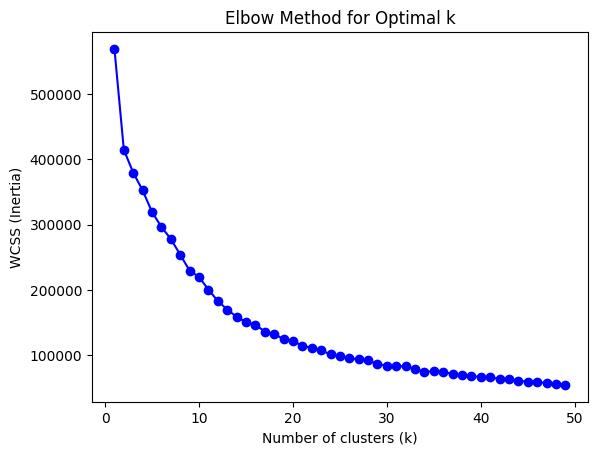

In [14]:
wcss = []
K = range(1, 50)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    kmeans.fit(X_sample)
    inertia = kmeans.inertia_ # inertia_ = WCSS
    print(f"k={k}, inertia={inertia:.4f}")
    wcss.append(inertia)  

# Plot the elbow
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()

The elbow point we choose is at `k` value 15

#### Silhouette Score

k=2, silhouette score=0.4415
k=3, silhouette score=0.3176
k=4, silhouette score=0.4378
k=5, silhouette score=0.3401
k=6, silhouette score=0.2854
k=7, silhouette score=0.3139
k=8, silhouette score=0.3213
k=9, silhouette score=0.3192
k=10, silhouette score=0.3522
k=11, silhouette score=0.3656
k=12, silhouette score=0.3746
k=13, silhouette score=0.3992
k=14, silhouette score=0.4021
k=15, silhouette score=0.4093
k=16, silhouette score=0.3946
k=17, silhouette score=0.4196
k=18, silhouette score=0.4285
k=19, silhouette score=0.4407
k=20, silhouette score=0.4321
k=21, silhouette score=0.3945
k=22, silhouette score=0.4140
k=23, silhouette score=0.4097
k=24, silhouette score=0.4697
k=25, silhouette score=0.4261
k=26, silhouette score=0.4342
k=27, silhouette score=0.3932
k=28, silhouette score=0.4231
k=29, silhouette score=0.4427


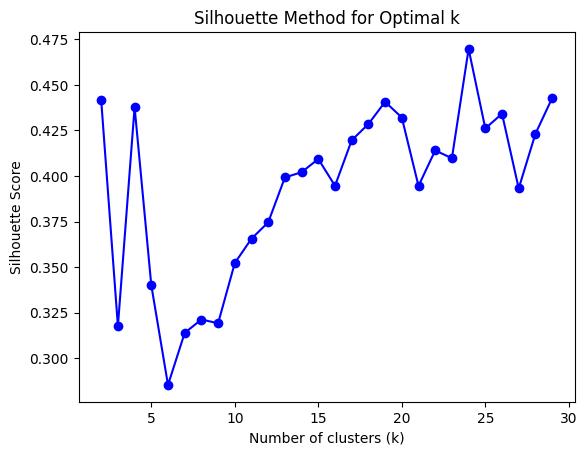

In [15]:
s_scores = []
K = range(2, 30)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_SEED)
    labels = kmeans.fit_predict(X_sample)
    score = silhouette_score(X_sample, labels)
    print(f"k={k}, silhouette score={score:.4f}")
    s_scores.append(score)
    
# Plot
plt.plot(K, s_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

### Model Training

In [16]:
kmeans = KMeans(n_clusters=24, random_state=RANDOM_SEED)
kmeans_labels = kmeans.fit_predict(X_sample)

## DBSCAN Clustering

### Setup DBSCAN

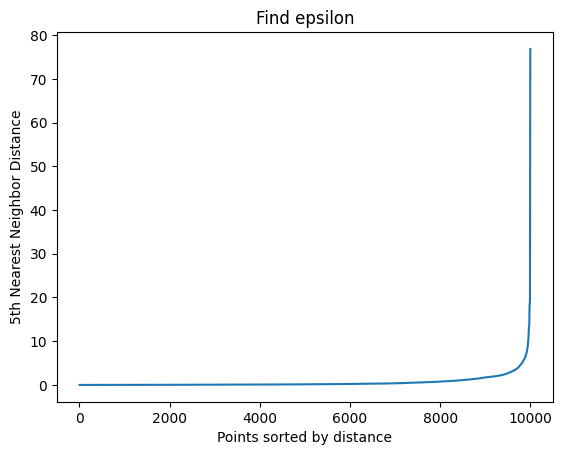

In [17]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(X_sample)
distances, indices = nbrs.kneighbors(X_sample)

distances = np.sort(distances[:, 4])  # 4 = n_neighbors - 1

# Plot
plt.plot(distances)
plt.ylabel("5th Nearest Neighbor Distance")
plt.xlabel("Points sorted by distance")
plt.title("Find epsilon")
plt.show()

Based on the visualization, the epsilon maybe at `4-5`

### Model Training

In [18]:
dbscan = DBSCAN(eps=4, min_samples=15)
dbscan_labels = dbscan.fit_predict(X_sample)

In [19]:
score = silhouette_score(X_sample, dbscan_labels)
print("Silhouette Score (DBSCAN):", score)

Silhouette Score (DBSCAN): 0.29948464091217386


# 3. Evaluate and Interpret

In [20]:
df_sample['Cluster_KMeans'] = kmeans_labels
df_sample['Cluster_DBSCAN'] = dbscan_labels
df_sample['Label'] = df_sample['Label'].astype('category')

print(df_sample.groupby(['Cluster_KMeans', 'Label']).size())
print(df_sample.groupby(['Cluster_DBSCAN', 'Label']).size())

Cluster_KMeans  Label           
0               BENIGN              483
                DoS GoldenEye         0
                DoS Hulk             16
                DoS Slowhttptest      0
                DoS slowloris         9
                                   ... 
23              DoS GoldenEye         1
                DoS Hulk            116
                DoS Slowhttptest      0
                DoS slowloris         1
                Heartbleed            0
Length: 144, dtype: int64
Cluster_DBSCAN  Label           
-1              BENIGN               291
                DoS GoldenEye          6
                DoS Hulk              65
                DoS Slowhttptest      23
                DoS slowloris         11
                Heartbleed             0
 0              BENIGN              5122
                DoS GoldenEye        111
                DoS Hulk            1250
                DoS Slowhttptest       5
                DoS slowloris         45
                H

# 4. Visualization

## k-Means

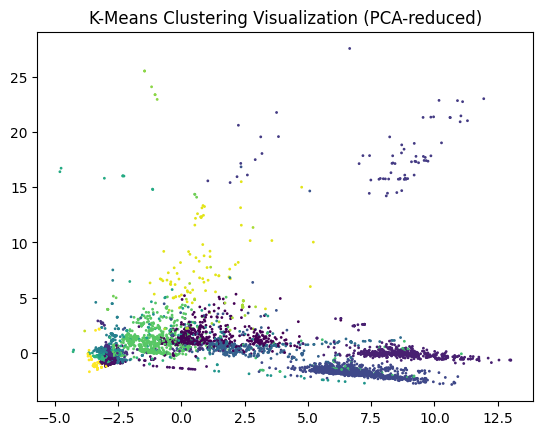

In [21]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(X_sample)

plt.scatter(reduced[:, 0], reduced[:, 1], c=kmeans_labels, cmap='viridis', s=1)
plt.title("K-Means Clustering Visualization (PCA-reduced)")
plt.show()

## DBSCAN

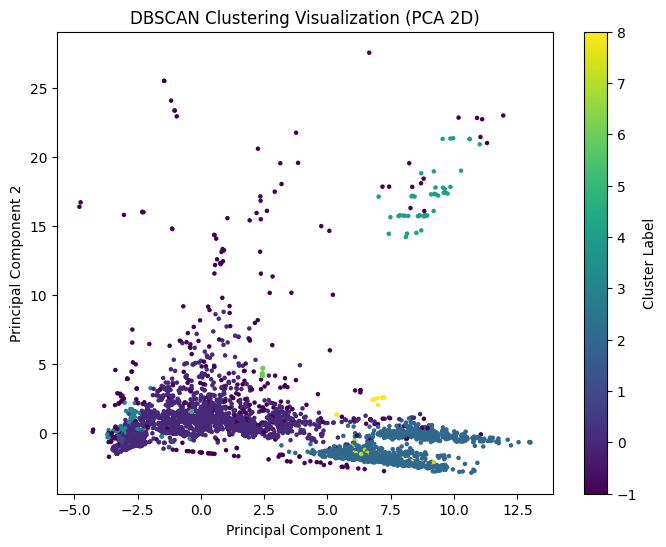

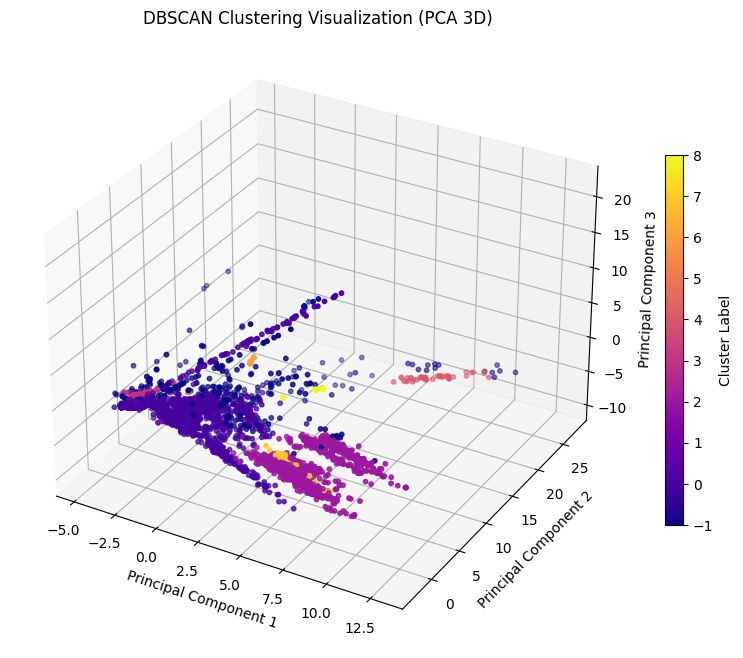

In [22]:
# PCA 2D
pca_2d = PCA(n_components=2)
reduced_2d = pca_2d.fit_transform(X_sample)

# PCA 3D
pca_3d = PCA(n_components=3)
reduced_3d = pca_3d.fit_transform(X_sample)

# DBSCAN labels
labels = dbscan_labels

# 2D Plot
plt.figure(figsize=(8, 6))
plt.scatter(
    reduced_2d[:, 0], reduced_2d[:, 1],
    c=labels,
    cmap='viridis',
    s=5
)
plt.title("DBSCAN Clustering Visualization (PCA 2D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='Cluster Label')
plt.show()

# 3D Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    reduced_3d[:, 0],
    reduced_3d[:, 1],
    reduced_3d[:, 2],
    c=labels,
    cmap='plasma',
    s=10
)

ax.set_title("DBSCAN Clustering Visualization (PCA 3D)")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")

fig.colorbar(scatter, label='Cluster Label', shrink=0.6)
plt.show()